In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from tqdm import tqdm_notebook as tqdm 
%matplotlib inline

In [140]:
def read_results(path = './baseline-runs/task1-bm25/'):
    
    to_read = [f for f in listdir(path) if isfile(join(path, f))]
    all_results = pd.DataFrame()
    
    if 'lucene' in path: sep = ' '
    else: sep = '\t'
    
    for files in to_read:
            
        all_results = all_results.append(pd.read_csv(path + str(files),\
                                  names = ['qid', 'Q0', 'result', 'rank', 'score', 'system'], sep = sep))
        
    if 'lucene' in path:
        
        all_results['result'] = all_results['result'].str.replace('.', '')


    return all_results

      
    
def get_mrr(all_results, query_feedback):
    
    mrr                      = []
    all_results['relevance'] = False

    
    for qid in query_feedback['qid'].unique():
        
        mrr_per_query            = []
        feedback_result          = list(query_feedback.loc[query_feedback['qid'] == qid]['result'])
       
        
        for result in feedback_result:
            
            result_index = all_results.loc[(all_results['qid'] == qid) \
                                           & (all_results['result'] == result)].index.tolist()
            
            all_results.loc[(all_results['qid'] == qid) \
                                           & (all_results['result'] == result), 'relevance'] = True 
            
            if len(result_index) > 0: 
                mrr_per_query.append(result_index[0] + 1)
                
        
        if len(mrr_per_query) != 0: mrr.append(1/min(mrr_per_query))
        else: mrr.append(0)
         
    return np.mean(mrr), all_results

In [120]:
def calc_precision_recall(all_results, query_feedback):
    
    recall = []
    precision = []
    remove_list = set()
    
    for qid in tqdm(range(1,len(all_results['qid'].unique()) + 1)):
        
        all_results.loc[(all_results['qid'] == qid), 'relevant_len'] \
                            = len(query_feedback.loc[(query_feedback['qid'] == qid)])
            
        recall_numerator = 0
        
        for index,row in all_results.loc[all_results['qid'] == qid].iterrows():
            
            if qid in list(query_feedback['qid']):
            
                if(row['relevance']): 

                    recall_numerator += 1
                    recall.append(recall_numerator/(row['relevant_len']))
                    precision.append(recall_numerator/row['rank'])


                else: 
                    recall.append(recall_numerator/row['relevant_len'])
                    precision.append(recall_numerator/row['rank'])
            
            else:
                #all_results = all_results.drop(qid, axis = 0)
                recall.append(0)
                precision.append(0)
                remove_list.add(qid)
    

    
    all_results['recall'] = recall
    all_results['precision'] = precision
    all_results = all_results[~all_results['qid'].isin(remove_list)]
    
    return all_results

In [102]:
def calc_metrics(all_results):
    
    #recall_precision = pd.DataFrame()
    
    mean_avg_precision = np.mean(all_results[all_results['relevance']][['precision', 'qid']].groupby('qid').sum() /\
                        all_results[all_results['relevance']][['precision', 'qid']].groupby('qid').count())
    
    recall_precision = all_results.loc[all_results['rank'] == 5][['qid','precision']].set_index('qid')
    recall_precision['precision@20'] = all_results.loc[all_results['rank'] == 20][['qid','precision']].set_index('qid')
    recall_precision.columns = ['precision@5', 'precision@20']
    
    recall_plot_df = pd.DataFrame()
    precision_plot_df = pd.DataFrame()
    precision_recall_plot = pd.DataFrame()

    for qid in all_results['qid'].unique():

        recall_plot_df['qid_' + str(qid)] = all_results.loc[all_results['qid'] == qid, 'recall']

    for qid in all_results['qid'].unique():

        precision_plot_df['qid_' + str(qid)] = all_results.loc[all_results['qid'] == qid, 'precision']


    recall_plot_df['mean'] = recall_plot_df.mean(axis = 1)
    precision_plot_df['mean'] = precision_plot_df.mean(axis = 1)


    precision_recall_plot['mean_precision'] = precision_plot_df['mean']
    precision_recall_plot['mean_recall'] = recall_plot_df['mean']
    
    return mean_avg_precision, recall_precision, precision_recall_plot, all_results

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.18006
dtype: float64
MRR:0.6615012030453206
      precision@5  precision@20
qid                            
38.0          0.0          0.10
10.0          0.6          0.15
11.0          0.0          0.00
39.0          0.2          0.10
13.0          0.2          0.10
12.0          0.4          0.10
16.0          0.6          0.25
9.0           0.2          0.10
8.0           0.4          0.20
17.0          0.6          0.60
15.0          0.6          0.40
29.0          0.4          0.10
28.0          0.6          0.20
14.0          0.2          0.25
58.0          0.2          0.15
64.0          0.2          0.20
59.0          0.6          0.20
61.0          0.0          0.15
49.0          1.0          0.30
48.0          0.4          0.10
60.0          0.0          0.05
62.0          0.4          0.25
63.0          0.6          0.20
45.0          0.4          0.50
44.0          0.0          0.05
40.0          0.0          0.00
43.0          0.4   

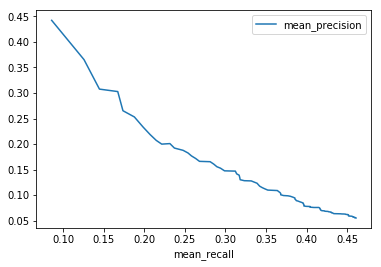

In [110]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-bm25/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.020737
dtype: float64
MRR:0.01884828471676002
      precision@5  precision@20
qid                            
38.0          0.0          0.00
10.0          0.0          0.00
11.0          0.0          0.00
39.0          0.0          0.00
13.0          0.0          0.00
12.0          0.0          0.00
16.0          0.0          0.00
9.0           0.0          0.00
8.0           0.0          0.00
17.0          0.0          0.00
15.0          0.0          0.00
29.0          0.0          0.00
28.0          0.0          0.00
14.0          0.2          0.10
58.0          0.0          0.00
64.0          0.0          0.00
59.0          0.0          0.00
61.0          0.0          0.00
49.0          0.0          0.05
48.0          0.0          0.00
60.0          0.0          0.00
62.0          0.0          0.00
63.0          0.0          0.00
45.0          0.0          0.05
44.0          0.0          0.00
40.0          0.0          0.00
43.0          0.0 

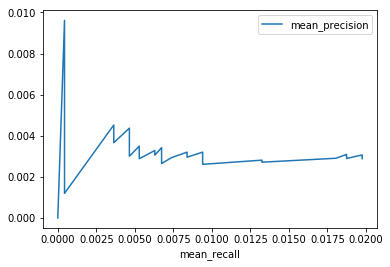

In [109]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-jmql/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.107685
dtype: float64
MRR:0.42781569444412615
      precision@5  precision@20
qid                            
38.0          0.0          0.00
10.0          0.2          0.10
11.0          0.0          0.00
39.0          0.2          0.10
13.0          0.2          0.05
12.0          0.0          0.10
16.0          0.2          0.30
9.0           0.0          0.05
8.0           0.2          0.15
17.0          0.0          0.30
15.0          0.6          0.25
29.0          0.4          0.10
28.0          0.4          0.20
14.0          0.6          0.25
58.0          0.2          0.15
64.0          0.0          0.05
59.0          0.2          0.10
61.0          0.0          0.05
49.0          0.0          0.15
48.0          0.0          0.00
60.0          0.2          0.05
62.0          0.8          0.35
63.0          0.4          0.20
45.0          0.8          0.45
44.0          0.2          0.05
40.0          0.0          0.00
43.0          0.4 

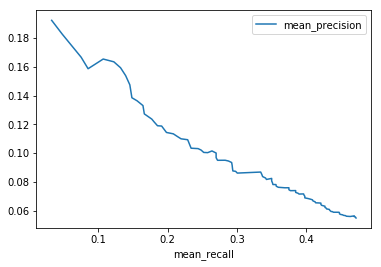

In [112]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-tfidf/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.146753
dtype: float64
MRR:0.6031901650650162
     precision@5  precision@20
qid                           
38           0.0          0.10
10           0.6          0.15
11           0.0          0.05
39           0.2          0.10
13           0.2          0.10
12           0.4          0.10
16           0.6          0.25
9            0.2          0.10
8            0.4          0.15
17           0.4          0.55
15           0.8          0.20
29           0.2          0.10
28           0.2          0.20
14           0.2          0.20
58           0.2          0.15
64           0.2          0.20
59           0.4          0.20
61           0.0          0.10
49           0.2          0.15
48           0.4          0.10
60           0.0          0.05
62           0.4          0.25
63           0.2          0.15
45           0.2          0.50
44           0.0          0.05
40           0.0          0.00
43           0.4          0.40
57           0.2

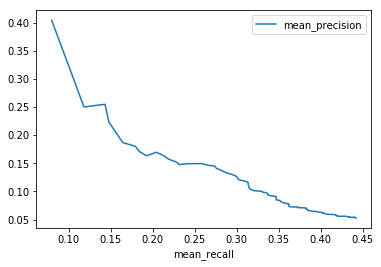

In [113]:
query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task2-bm25-pseudo-relevance/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.162316
dtype: float64
MRR:0.6646520146520147
     precision@5  precision@20
qid                           
38      0.200000      0.100000
10      0.600000      0.150000
11      0.066667      0.033333
39      0.133333      0.066667
13      0.133333      0.066667
12      0.133333      0.100000
16      0.266667      0.200000
9       0.133333      0.066667
8       0.200000      0.166667
17      0.733333      0.500000
15      0.466667      0.266667
29      0.133333      0.133333
28      0.266667      0.233333
14      0.200000      0.166667
58      0.133333      0.100000
64      0.200000      0.233333
59      0.266667      0.200000
61      0.133333      0.100000
49      0.400000      0.200000
48      0.133333      0.066667
60      0.133333      0.133333
62      0.466667      0.300000
63      0.266667      0.133333
45      0.600000      0.366667
44      0.066667      0.033333
40      0.066667      0.033333
43      0.400000      0.400000
57      0.266667

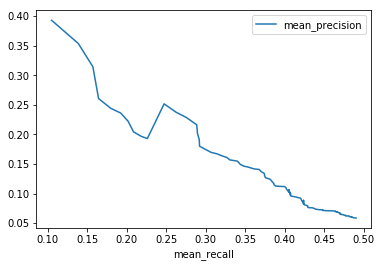

In [134]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task3-bm25-stopping/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.01897
dtype: float64
MRR:0.06725761848636325
     precision@5  precision@20
qid                           
38      0.000000      0.000000
10      0.000000      0.000000
11      0.000000      0.000000
39      0.000000      0.000000
13      0.000000      0.000000
12      0.000000      0.033333
16      0.066667      0.100000
9       0.000000      0.000000
8       0.000000      0.000000
17      0.000000      0.000000
15      0.000000      0.033333
29      0.000000      0.000000
28      0.066667      0.033333
14      0.133333      0.133333
58      0.000000      0.033333
64      0.000000      0.000000
59      0.066667      0.033333
61      0.000000      0.033333
49      0.066667      0.033333
48      0.000000      0.000000
60      0.000000      0.000000
62      0.133333      0.066667
63      0.000000      0.000000
45      0.066667      0.033333
44      0.066667      0.066667
40      0.000000      0.000000
43      0.000000      0.000000
57      0.000000

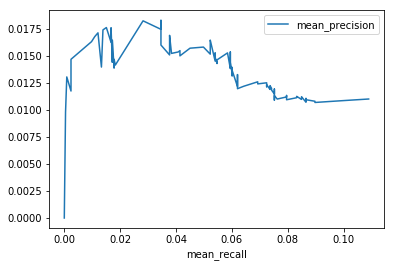

In [133]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task3-JMQL-stopping/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.132989
dtype: float64
MRR:0.5408848096348096
     precision@5  precision@20
qid                           
38      0.000000      0.050000
10      0.600000      0.150000
11      0.000000      0.033333
39      0.200000      0.100000
13      0.066667      0.133333
12      0.133333      0.100000
16      0.466667      0.466667
9       0.066667      0.033333
8       0.200000      0.166667
17      0.466667      0.400000
15      0.400000      0.233333
29      0.133333      0.100000
28      0.333333      0.166667
14      0.266667      0.166667
58      0.133333      0.133333
64      0.000000      0.033333
59      0.200000      0.166667
61      0.066667      0.100000
49      0.333333      0.200000
48      0.066667      0.066667
60      0.066667      0.066667
62      0.466667      0.266667
63      0.266667      0.133333
45      0.533333      0.333333
44      0.200000      0.100000
40      0.066667      0.033333
43      0.266667      0.200000
57      0.200000

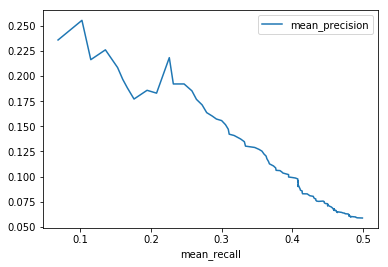

In [131]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task3-TFIDF-stopping/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.132989
dtype: float64
MRR:0.5408848096348096
     precision@5  precision@20
qid                           
38      0.000000      0.050000
10      0.600000      0.150000
11      0.000000      0.033333
39      0.200000      0.100000
13      0.066667      0.133333
12      0.133333      0.100000
16      0.466667      0.466667
9       0.066667      0.033333
8       0.200000      0.166667
17      0.466667      0.400000
15      0.400000      0.233333
29      0.133333      0.100000
28      0.333333      0.166667
14      0.266667      0.166667
58      0.133333      0.133333
64      0.000000      0.033333
59      0.200000      0.166667
61      0.066667      0.100000
49      0.333333      0.200000
48      0.066667      0.066667
60      0.066667      0.066667
62      0.466667      0.266667
63      0.266667      0.133333
45      0.533333      0.333333
44      0.200000      0.100000
40      0.066667      0.033333
43      0.266667      0.200000
57      0.200000

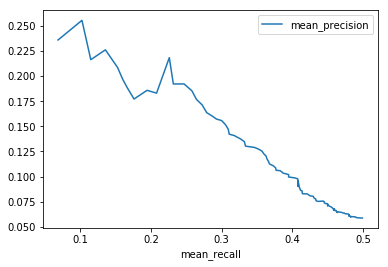

In [132]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task3-TFIDF-stopping/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')

HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


Mean Average Precision: precision    0.203649
dtype: float64
MRR:0.65459590173659
     precision@5  precision@20
qid                           
38           0.4          0.10
10           0.6          0.15
11           0.0          0.00
39           0.4          0.10
13           0.4          0.10
12           0.2          0.10
16           0.6          0.35
9            0.4          0.10
8            0.4          0.15
17           0.8          0.60
15           0.6          0.45
29           0.4          0.10
28           0.6          0.20
14           0.0          0.10
58           0.2          0.15
64           0.2          0.10
59           0.4          0.20
61           0.0          0.15
49           0.6          0.30
48           0.6          0.15
60           0.4          0.15
62           0.8          0.65
63           0.6          0.15
45           0.2          0.35
44           0.2          0.05
40           0.0          0.00
43           0.4          0.45
57           0.2  

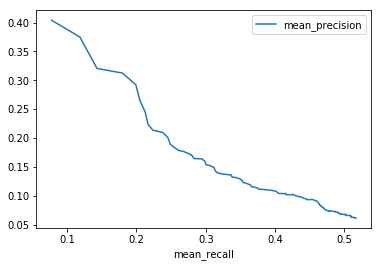

In [141]:

query_feedback   = pd.read_csv('test-collection/cacm.rel.txt',
                                       names = ['qid', 'Q0', 'result', 'rank'], sep = ' ')
all_results      = read_results('./baseline-runs/task1-lucene_evaluations/')
all_results      = all_results.loc[~all_results['qid'].isnull()]
mrr, all_results = get_mrr(all_results, query_feedback)
all_results      = calc_precision_recall(all_results, query_feedback)
mean_avg_precision,\
recall_precision,\
precision_recall_plot,\
all_results     = calc_metrics(all_results)

print('Mean Average Precision: ' + str(mean_avg_precision) +
      '\nMRR:' + str(mrr))
print (recall_precision)
print (all_results)
precision_recall_plot.sort_values('mean_recall').plot(x= 'mean_recall', y='mean_precision')